In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.panda_mj_description import MJCF_PATH
from scripts.utils import update_actuator, ActuatorMotor

# np.random.seed(0)

In [2]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "hand")

ee_body

MJCF Element: <body name="hand" pos="0 0 0.107" quat="0.92387949999999996 0 0 -0.38268340000000001">...</body>

In [3]:
MJCF_PATH

'/home/simeon/.cache/robot_descriptions/mujoco_menagerie/franka_emika_panda/panda.xml'

In [4]:
# load_mass.add("inertial", mass=f"{M}", pos=f"{rc[0]} {rc[1]} {rc[2]}", diaginertia=f"{I} {I} {I}")

In [5]:
# old model
old_model = mujoco.MjModel.from_xml_path(MJCF_PATH)
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# create new body
rc = np.array([0., 0.0, 0.0])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1"
)

M = 2.0
# R = 0.0001
I = 1e-3#M * rc[0]**2

load_mass.add("inertial", mass=f"{M}", pos=f"0 0 0", diaginertia=f"{1e-3} {1e-3} {1e-3}")

# disable collision for all the geoms
for geom in mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

""

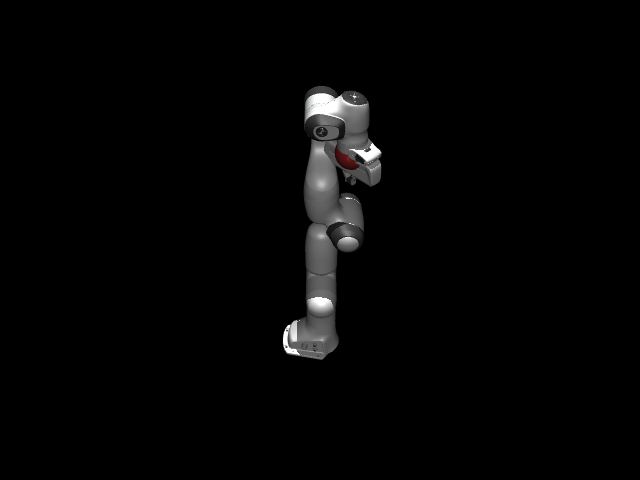

In [6]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [7]:
def staticload_joint_regressor(mj_model, mj_data, ee_id, active_joints = 7, body_offset = 0):

    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id+body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0,0,9.81]) #

    static_load_regressor = np.array([[a1, 0, 0, 0],
                                      [a2, 0, 0, 0],
                                      [a3, 0, 0, 0],
                                      [0, 0, a3, -a2],
                                      [0, -a3, 0, a1],
                                      [0, a2, -a1, 0]])
    
    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack((rotation.T@jac_lin[:, :active_joints],
                                   rotation.T@jac_rot[:, :active_joints]))
    joint_regressor = ee_local_jacobian.T @ static_load_regressor
    
    return joint_regressor

In [8]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq - 2), np.zeros(sim_model.nq - 2)
for jnt_idx in range(sim_model.nq - 2):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

kp = 50
kd = 10
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

phase_time = 5.0
num_of_phases = 50
phases = 0
old_data.time = 0 
sim_data.time = 0

# print(sim_model.nq)
load_joint_regressor = np.zeros(((sim_model.nq-2)*num_of_phases, 4))
load_joint_force = np.zeros(((sim_model.nq-2))*num_of_phases)
active_joints = (sim_model.nq-2)

while sim_data.time < num_of_phases*phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    target_acc = kp * (target_q - sim_data.qpos[:-2]) + kd * (
        np.zeros(sim_model.nv - 2) - sim_data.qvel[:-2]
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc[:-2] = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl[:-1] = sol[:-2]

    if sim_data.time > phase_time * phases and sim_data.time < num_of_phases*phase_time: 
        # print(load_force)
        regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
        load_joint_regressor[7*phases: 7*(phases+1), :] = regressor
        
        load_qforce = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7*phases: 7*(phases+1)] = load_qforce.copy()
        actual_load_qforce = regressor@np.array([M,*(M*rc)])
        
        print(load_qforce)
        
        phases += 1
        target_q = np.random.uniform(lower, upper)
        
         
    
#     if len(frames) < sim_data.time * framerate:
#         renderer.update_scene(sim_data)
#         frames.append(renderer.render())
        

# media.show_video(frames, fps=framerate)

[ 1.31494211e+00  1.91545327e+02 -8.58253052e-01  1.27852178e+02
 -1.63287727e+01 -1.16199225e+03  4.05524163e+01]
[-3.96248895e-06  7.17072309e+00 -9.85052890e+00  9.79522061e-02
  1.12067758e+00  4.25387684e-01  3.37014852e-08]
[ 1.45827999e-05  7.49398317e+00 -5.38184101e+00  7.45649451e+00
 -2.17438941e-01  2.69759160e+00 -2.52347736e-08]
[-3.32254804e-04  6.46365271e+00  2.33734944e+00  9.24943818e+00
 -1.43336593e-03  2.70403488e+00  7.08193766e-07]
[-1.56015583e-05  1.05542805e+01  2.99445183e+00  4.68950685e+00
  4.84406222e-01  3.22154165e-01  1.69602403e-07]
[-8.10576288e-06 -7.76775757e-01 -1.61072549e+00  6.05483722e+00
 -2.08827254e+00 -5.34773898e-01  2.43526490e-08]
[-3.50188338e-06 -1.32095118e+01 -9.01620411e+00 -1.74471772e+00
  1.94613649e-01 -2.27463016e+00 -3.57843343e-07]
[ 1.76554375e-06 -8.35261247e+00  8.57976204e+00  2.44729308e-02
 -2.14064072e+00  4.63140518e-01  1.14720109e-08]
[ 4.15722134e-04  1.46112822e+00  1.43460902e+00  2.42788556e+00
  1.37385101e-0

In [9]:
params_estimates = np.linalg.pinv(load_joint_regressor[7:,:])@load_joint_force[7:]
mass = params_estimates[0]
coordinate = params_estimates[1:]/mass
mass, coordinate

(1.578157784656949, array([-0.2226265 , -0.8427441 , -0.81156608]))

In [10]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),
    lambda x: (load_joint_regressor[7:] @ x - load_joint_force[7:]) ** 2,
)
estimates = result[0]
mass = estimates[0]
coordinate = estimates[1:]/mass
mass, coordinate

Terminated after 0 iterations: insufficient reduction. y: 1.694e+12, Residual evals: 147
total time 1.9ms of which residual 33.0%


(1.0, array([1., 1., 1.]))

In [11]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: 1.01 actual: 1.03
joint 1 target: -1.09 actual: -1.09
joint 2 target: -1.62 actual: -1.72
joint 3 target: -2.04 actual: -2.08
joint 4 target: -0.34 actual: -0.49
joint 5 target: 0.20 actual: 0.42
joint 6 target: 1.92 actual: 1.91
